In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ProjectLab

Mounted at /content/drive
/content/drive/My Drive/ProjectLab


[Int64Index([   0,   17,   31,   35,   64,   65,  121,  122,  126,  133,  134,
             135,  137,  157,  172,  232,  236,  238,  277,  293,  295,  296,
             311,  349,  359,  362,  375,  410,  427,  453,  464,  472,  487,
             492,  495,  529,  576,  584,  604,  648,  681,  690,  747,  751,
             773,  791,  792,  804,  855,  875,  882,  899,  940,  943,  972,
            1027, 1033, 1038, 1041, 1077, 1114, 1129, 1163, 1175, 1189, 1212,
            1223, 1231, 1251, 1252, 1282, 1292, 1296, 1316, 1336],
           dtype='int64'), Int64Index([  15,   28,   63,   76,   80,  104,  105,  106,  117,  149,  150,
             205,  213,  241,  248,  249,  261,  270,  282,  291,  320,  326,
             363,  426,  428,  434,  451,  465,  468,  469,  504,  535,  583,
             585,  593,  636,  680,  684,  703,  727,  762,  784,  797,  802,
             809,  827,  871,  881,  885,  897,  910,  952,  954,  957,  965,
             977,  990,  993, 1016, 1023, 1026,

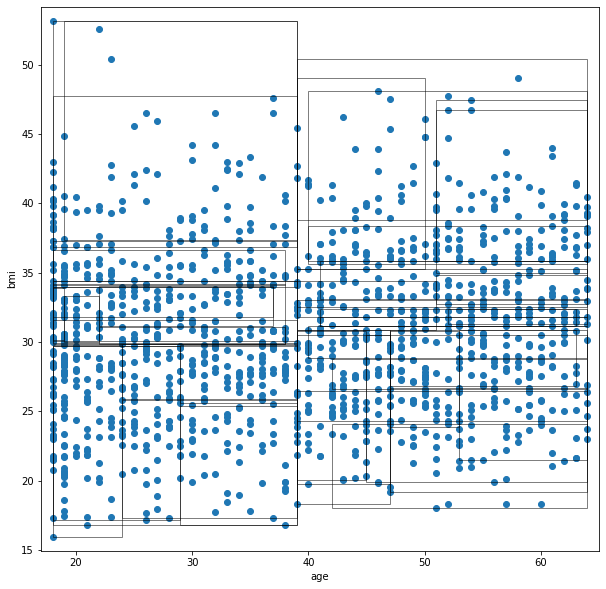

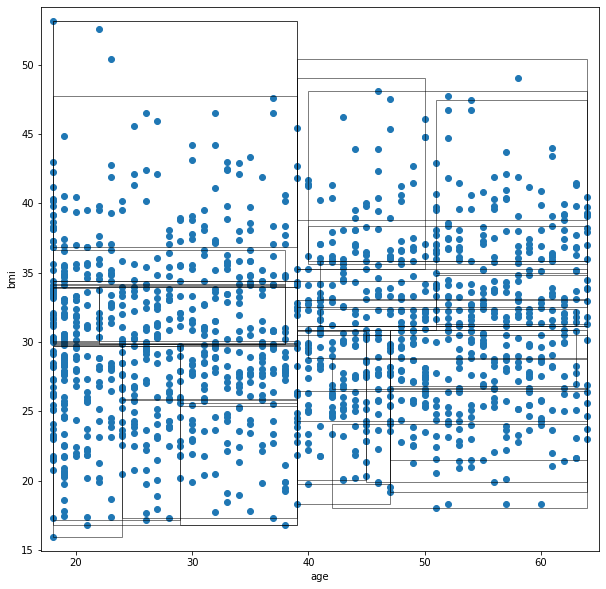

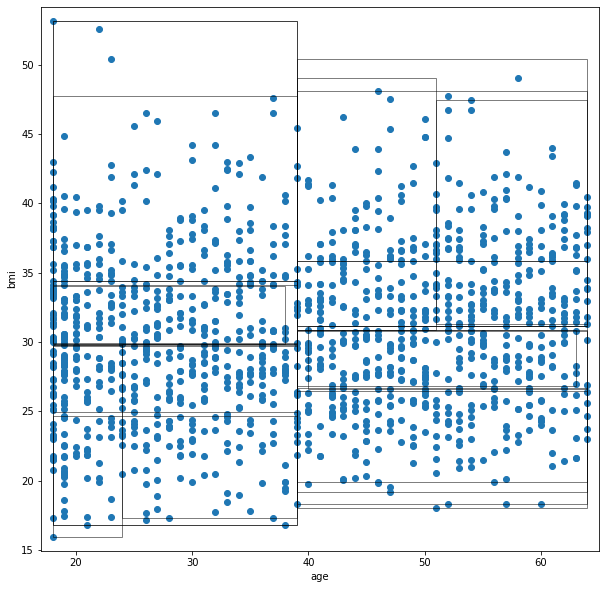

Finished 1 partitions...
Finished 1 partitions...
Finished 1 partitions...
           age        bmi  children Disease
37   22.128205  39.995769         0    AIDS
152  28.115385  31.778269         3    AIDS
139  28.421053  41.508421         1    AIDS
43   30.098039  38.528431         2    AIDS
124  30.611111  30.718889         1    AIDS
..         ...        ...       ...     ...
227  54.875000  38.551250         2   Tumor
232  55.625000  38.980313         3   Tumor
223  56.250000  33.620625         2   Tumor
214  56.705882  27.142353         3   Tumor
219  58.000000  31.954000         2   Tumor

[236 rows x 4 columns]
           age        bmi  children                 Disease
0    19.773333  24.973600         0                     FLU
1    19.773333  24.973600         0                  Cancer
2    19.773333  24.973600         0               Hepatitis
3    19.773333  24.973600         0                   Tumor
4    19.773333  24.973600         0  Bronchial Inflammation
..         ..

In [8]:
import pandas as pd
import matplotlib as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
df = pd.read_csv('PatientDiseaseData.csv')
df['sex']= df['sex'].map({'male':0,'female':1})
df['smoker']= df['smoker'].map({'yes':1,'no':0})
df['Disease'] = df['Disease'].map({'FLU':1,'Cancer' : 2, 'Hepatitis' : 3, 'Tumor' :4, 'Bronchial Inflammation':5,'Heart Disease':6,'Stomach Inflammation':7,'Bronchitus':8,'AIDS':9})
df['region'] = df['region'].map({'northwest':1,'northeast':2,'southeast':3,'southwest':4})
categorical = set((
    'sex',
    'smoker',
    'region',
    'Disease'
))
for name in categorical:
    df[name] = df[name].astype('category')
def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans
full_spans = get_spans(df, df.index)
def split(df, partition, column): 
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)
def is_k_anonymous(df, partition, sensitive_column, k=5):
    if len(partition) < k:
        return False
    return True
def diversity(df, partition, column):
    return len(df[column][partition].unique())
def is_k_anonymous1(df, partition, sensitive_column, k=20):
    if len(partition) < k:
        return False
    return True


def is_l_diverse(df, partition, sensitive_column, l=5):
    
    return diversity(df, partition, sensitive_column) >= l
def is_k_anonymous2(df, partition, sensitive_column, k=45):
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions
feature_columns = ['age', 'bmi', 'children']
sensitive_column = 'Disease'
finished_l_diverse_partitions1 = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))
finished_l_diverse_partitions2 = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous1(*args) and is_l_diverse(*args))
finished_l_diverse_partitions3 = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous2(*args) and is_l_diverse(*args))

print(finished_l_diverse_partitions1)
print(finished_l_diverse_partitions2)
print(finished_l_diverse_partitions3)
print(len(finished_l_diverse_partitions1))
print(len(finished_l_diverse_partitions2))
print(len(finished_l_diverse_partitions3))



def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects1 = get_partition_rects(df, finished_l_diverse_partitions1, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects2 = get_partition_rects(df, finished_l_diverse_partitions2, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects3 = get_partition_rects(df, finished_l_diverse_partitions3, column_x, column_y, indexes, offsets=[0.0, 0.0])

print(rects1)
print(rects2)
print(rects3)

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects1, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects2, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects3, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()


def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column

    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break

        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
       
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()   #ERROR HERE
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)
dfn1 = build_anonymized_dataset(df, finished_l_diverse_partitions1, feature_columns, sensitive_column)
dfn2 = build_anonymized_dataset(df, finished_l_diverse_partitions2, feature_columns, sensitive_column)
dfn3 = build_anonymized_dataset(df, finished_l_diverse_partitions3, feature_columns, sensitive_column)

dfn1["children"] = dfn1["children"].astype(int)
dfn1[sensitive_column] = dfn1[sensitive_column].astype(int)
dfn1[sensitive_column] = dfn1[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
print(dfn1.sort_values([ sensitive_column,column_x, column_y]))
dfn2["children"] = dfn2["children"].astype(int)
dfn2[sensitive_column] = dfn2[sensitive_column].astype(int)
dfn2[sensitive_column] = dfn2[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
print(dfn2)
dfn3["children"] = dfn3["children"].astype(int)
dfn3[sensitive_column] = dfn3[sensitive_column].astype(int)
dfn3[sensitive_column] = dfn3[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
print(dfn3.sort_values([sensitive_column,column_x,column_y]))



